# import

In [2]:
from fastai.imports import *
from fastai.text import *
from fastai.structured import *
from fastai.column_data import *
from torch.nn import functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
import random

In [51]:
import pdb
import gc
from collections import Counter

# read data

In [4]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=True, na_dict=None,
             preproc_fn=None, max_n_cat=10, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    if y_fld is not None: 
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    if y_fld is not None: 
        res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    else:
        res = [pd.get_dummies(df, dummy_na=True), na_dict]
    if do_scale: res = res + [mapper]
    return res

In [5]:
df_train = pd.read_csv('data/application_train.csv')
train_cats(df_train)
y_label = df_train['TARGET'].values
df_train = df_train.drop(columns = ['TARGET', 'SK_ID_CURR'])

In [6]:
x_train,x_valid, y_train, y_valid = train_test_split(df_train, y_label, test_size=0.25, stratify = y_label)

In [7]:
train_proc, train_na, mapper = proc_df2(x_train)
valid_proc, valid_na, _ =  proc_df2(x_valid, na_dict = train_na, mapper= mapper)

In [8]:
del df_train, y_label, x_train, x_valid; gc.collect()

154

# data loader

In [140]:
class ramdom_over_sampler(Sampler):
    def __init__(self, y):
        self.y = y
        
    def __len__(self): return (self.y == 0).sum()*2
    
    def __iter__(self):
        ros = RandomOverSampler(random_state=2368)
        x_samp, y_samp = ros.fit_sample(np.array(range(len(self.y))).reshape(-1, 1), self.y)
        x_samp = x_samp.reshape(-1)
        
        x_samp_n, x_samp_p = x_samp[y_samp == 0], x_samp[y_samp == 1]
        np.random.shuffle(x_samp_p)
        #np.random.shuffle(x_samp_n);
        ids = np.array([x_samp_n, x_samp_p]).T.flatten()
        
        return iter(ids)

In [9]:
class cstmz_dataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y

    def __len__(self): return len(self.y)
    
    def col_size(self): return self.x.shape[1]
        
    def __getitem__(self, idx):
        return [self.x.iloc[idx].values, self.y[idx]]

In [115]:
class cstmz_md(ModelData):    
    @classmethod
    def get_dataset(cls, path, x_tr, y_tr, x_val, y_val, tr_sampler = None, val_sampler = None, bs = 16):
        trn_ds = cstmz_dataset(x_tr, y_tr)
        val_ds = cstmz_dataset(x_val, y_val)
        return cls.get_dl(path, trn_ds, val_ds, tr_sampler, val_sampler, bs)
    
    @classmethod
    def get_dl(cls, path, trn_ds, val_ds, tr_sampler = None, val_sampler = None, bs = 16):
        trn_dl = DataLoader(dataset = trn_ds, batch_size = bs, sampler = tr_sampler)
        val_dl = DataLoader(dataset = val_ds, batch_size = bs, sampler = val_sampler)
        return cls(path, trn_dl, val_dl, None)

In [141]:
tr_sampler = ramdom_over_sampler(y_train)
val_sampler = ramdom_over_sampler(y_valid)

In [142]:
model_data = cstmz_md.get_dataset('', train_proc, y_train, valid_proc, y_valid, 
                                   tr_sampler = tr_sampler, val_sampler = val_sampler, bs = 64)

# Architechture

In [21]:
class bsc_ln(nn.Module):
    def __init__(self, ip_sz, op_sz, drp_rt = None):
        super().__init__()
        self.op_sz = op_sz
        self.ln = nn.Linear(ip_sz, op_sz)
        kaiming_normal(self.ln.weight.data)
        if drp_rt is not None:
            self.bn = nn.BatchNorm1d(op_sz)
            self.drp = nn.Dropout(drp_rt)        
        
    def forward(self, x):
        return self.drp(self.bn(F.relu(self.ln(x)))) if self.op_sz != 1 else F.sigmoid(self.ln(x))

In [22]:
class ctmz_Model(nn.Module):
    def __init__(self, layers, drp_rt):  
        super().__init__()
        lyrs = [model_data.trn_dl.dataset.col_size()] + layers + [1]    
        drp_rt = drp_rt + [None]
        self.lns = nn.ModuleList([bsc_ln(lyrs[i], lyrs[i+1], drp_rt[i]) for i in range(len(lyrs)-1)])
        
    def forward(self, x):
        for lyer in self.lns: x = lyer(x)
        return x

In [23]:
model = ctmz_Model(layers = [512, 256, 128, 64, 32], drp_rt = [0.2, 0.1, 0.15, 0.15, 0.25])

# leaner

In [143]:
def bce_loss(inp,targ):
    inp_flat = inp.view(-1); targ_flat = targ.float().view(-1)
    return F.binary_cross_entropy(inp_flat, targ_flat)

In [145]:
ff_learner = Learner.from_model_data(model, model_data)
ff_learner.crit = bce_loss

 87%|████████▋ | 5764/6626 [02:53<00:26, 33.15it/s, loss=0.97] 

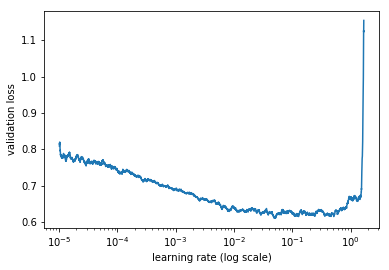

In [146]:
ff_learner.lr_find()
ff_learner.sched.plot()

In [147]:
lrs = 1e-1
ff_learner.fit(lrs, n_cycle = 5, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.603971   0.610238  
    1      0.599115   0.612082                                 
    2      0.604759   0.616319                                 
    3      0.604356   0.61665                                  
    4      0.596816   0.618112                                 


[array([0.61811])]